# Wafer Scratch Detection Assignment

**Wafer Scratch Detection – Project Summary**  
This project presents a solution for detecting surface scratches on semiconductor wafers using machine learning techniques. The workflow begins with thorough data exploration and preprocessing, including handling missing values, removing anomalies, and applying appropriate scaling and feature engineering to prepare the data for modeling.

A LightGBM classifier was chosen for its efficiency and strong performance with structured, tabular datasets. To ensure optimal performance, hyperparameter tuning was performed using Optuna, a powerful and flexible optimization framework. The training and tuning process (and also other things like feature engineering) were accelerated through parallel optimization, allowing multiple trials to run simultaneously and significantly reducing computation time.  
  
**Written By: Itay Chabra**

### Imports

In [1]:
import pandas as pd
import numpy as np
import zipfile
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GroupKFold, GroupShuffleSplit
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import xgboost as xgb
from scipy.ndimage import convolve
import warnings
from IPython.display import display
import copy
from scipy.ndimage import convolve, label
from joblib import Parallel, delayed
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
import optuna
import time
import random
from collections import Counter
warnings.filterwarnings('ignore')

### Load Data

In [2]:
#load zip file
zf = zipfile.ZipFile('data.zip') 

In [3]:
#load train data
df_wafers = pd.read_csv(zf.open('wafers_train.csv'))
df_wafers.head()

,WaferName,DieX,DieY,IsGoodDie,IsScratchDie
0,8PFrAN,0,27,True,False
1,8PFrAN,0,28,True,False
2,8PFrAN,0,29,True,False
3,8PFrAN,0,30,True,False
4,8PFrAN,0,31,True,False


In [4]:
#load test data
df_wafers_test = pd.read_csv(zf.open('wafers_test.csv'))
df_wafers_test.head()

,WaferName,DieX,DieY,IsGoodDie
0,mZa9ls,0,23,True
1,mZa9ls,0,24,True
2,mZa9ls,0,25,True
3,mZa9ls,0,26,True
4,mZa9ls,0,27,True


Helper function to draw the wafer maps with or without labels (to be used later)

In [5]:
def plot_wafer_maps(wafer_df_list, figsize, labels = True):
    """
    plot wafer maps for list of df of wafers

    :param wafer_df_list: list, The list of df's of the wafers
    :param figsize: int, the size of the figsize height 
    :param labels: bool, Whether to show the layer of labels (based on column 'IsScratchDie')
    
    :return: None
    """
    def plot_wafer_map(wafer_df, ax, map_type):
        wafer_size = len(wafer_df)
        s = 2**17/(wafer_size)
        if map_type == 'Label':
            mes = 'Scratch Wafer' if (wafer_df['IsScratchDie'] == True).sum()>0 else 'Non-Scratch Wafer'
        else:
            mes = 'Yield: ' + str(round((wafer_df['IsGoodDie']).sum()/(wafer_df['IsGoodDie']).count(), 2)) 
        
        ax.set_title(f'{map_type} | Wafer Name: {wafer_df["WaferName"].iloc[0]}, \nSum: {len(wafer_df)} dies. {mes}', fontsize=20)
        ax.scatter(wafer_df['DieX'], wafer_df['DieY'], color = 'green', marker='s', s = s)

        bad_bins = wafer_df.loc[wafer_df['IsGoodDie'] == False]
        ax.scatter(bad_bins['DieX'], bad_bins['DieY'], color = 'red', marker='s', s = s)
        
        if map_type == 'Label':
            scratch_bins = wafer_df.loc[(wafer_df['IsScratchDie'] == True) & (wafer_df['IsGoodDie'] == False)]
            ax.scatter(scratch_bins['DieX'], scratch_bins['DieY'], color = 'blue', marker='s', s = s)

            ink_bins = wafer_df.loc[(wafer_df['IsScratchDie'] == True) & (wafer_df['IsGoodDie'] == True)]
            ax.scatter(ink_bins['DieX'], ink_bins['DieY'], color = 'yellow', marker='s', s = s)

            ax.legend(['Good Die', 'Bad Die', 'Scratch Die', 'Ink Die'], fontsize=8)
        else:
            ax.legend(['Good Die', 'Bad Die'], fontsize=8)

        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False) 
    
    if labels:
        fig, ax = plt.subplots(2, len(wafer_df_list), figsize=(figsize*len(wafer_df_list), figsize*2))
        for idx1, wafer_df in enumerate(wafer_df_list):
            for idx2, map_type in enumerate(['Input', 'Label']):
                plot_wafer_map(wafer_df, ax[idx2][idx1], map_type)
    else:
        fig, ax = plt.subplots(1, len(wafer_df_list), figsize=(figsize*len(wafer_df_list), figsize))
        for idx, wafer_df in enumerate(wafer_df_list):
            plot_wafer_map(wafer_df, ax[idx], 'Input')

    plt.show()

## Exploratory Data Analysis 

DataFrame Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10415400 entries, 0 to 10415399
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   WaferName     object
 1   DieX          int64 
 2   DieY          int64 
 3   IsGoodDie     bool  
 4   IsScratchDie  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 258.3+ MB

Data Summary:


,DieX,DieY,IsGoodDie,IsScratchDie
count,10415400.00,10415400.00,10415400.00,10415400.00
mean,28.93,28.93,0.96,0.01
std,16.03,16.03,0.19,0.09
min,0.00,0.00,0.00,0.00
25%,16.00,16.00,1.00,0.00
50%,28.00,28.00,1.00,0.00
75%,41.00,41.00,1.00,0.00
max,70.00,70.00,1.00,1.00



Missing Values:


,Column,Missing Count
0,WaferName,0
1,DieX,0
2,DieY,0
3,IsGoodDie,0
4,IsScratchDie,0



Class Distribution:


,Metric,Count
0,Total Dies,10415400
1,Good Dies,10036478
2,Bad Dies,378922
3,Scratch Dies,80319
4,Ink Dies,12568
5,Bad Scratch Dies,67751



Wafer-Level Statistics:


,TotalDies,GoodDies,ScratchDies,Yield,HasScratch
WaferName,,,,,
00Q792,1941,1881,8,0.969088,True
01hHtd,1005,978,17,0.973134,True
042xYr,2449,2363,1,0.964884,True
04XRmn,2997,2845,19,0.949283,True
04kats,4049,3880,34,0.958261,True
04m8dM,1513,1489,1,0.984137,True
05OItq,2997,2864,27,0.955622,True
05OOTD,1941,1860,16,0.958269,True
061shK,1941,1905,1,0.981453,True



Wafer Yield Summary:


,Yield
count,4200.0000
mean,0.9629
std,0.0110
min,0.9002
25%,0.9551
50%,0.9630
75%,0.9712
max,0.9891



Wafers with scratches: 4073
Wafers without scratches: 127

Minimum yield of wafers with scratches: 0.9002

Yield Percentiles:
0.01    0.9365
0.05    0.9445
0.10    0.9486
0.25    0.9551
0.50    0.9630
0.75    0.9712
0.90    0.9771
0.95    0.9800
0.99    0.9839
Name: Yield, dtype: object


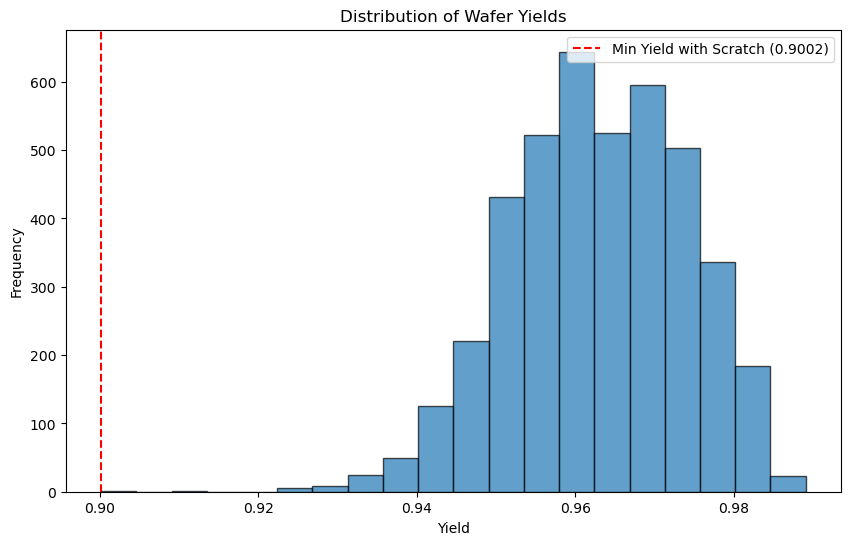


Percentage of wafers classified as low yield for different thresholds:
Threshold 0.9365: 1.00%, 42/42 wafers below threshold have scratches
Threshold 0.9445: 4.90%, 206/206 wafers below threshold have scratches
Threshold 0.9486: 10.00%, 418/420 wafers below threshold have scratches
Threshold 0.9002: 0.00%, 0/0 wafers below threshold have scratches
Threshold 0.90: 0.00%, 0/0 wafers below threshold have scratches
Threshold 0.91: 0.02%, 1/1 wafers below threshold have scratches
Threshold 0.92: 0.05%, 2/2 wafers below threshold have scratches
Threshold 0.93: 0.36%, 15/15 wafers below threshold have scratches
Threshold 0.94: 2.14%, 90/90 wafers below threshold have scratches
Threshold 0.95: 12.24%, 512/514 wafers below threshold have scratches
Threshold 0.96: 40.17%, 1671/1687 wafers below threshold have scratches


In [6]:
# Create a copy for EDA
df_wafers_eda = df_wafers.copy()

# Convert boolean columns to integers
df_wafers_eda['IsGoodDie'] = df_wafers_eda['IsGoodDie'].astype(int)
df_wafers_eda['IsScratchDie'] = df_wafers_eda['IsScratchDie'].astype(int)

# Basic information
print("DataFrame Info")
df_wafers.info()

# Summary statistics
print("\nData Summary:")
display(df_wafers_eda.describe().apply(lambda x: x.apply(lambda y: f"{y:.2f}")))

# Missing values
print("\nMissing Values:")
missing_df = df_wafers.isnull().sum().reset_index().rename(columns={0: 'Missing Count', 'index': 'Column'})
display(missing_df)

# Class distribution
class_distribution = pd.DataFrame({
    'Metric': ['Total Dies', 'Good Dies', 'Bad Dies', 'Scratch Dies', 'Ink Dies', 'Bad Scratch Dies'],
    'Count': [
        len(df_wafers),
        df_wafers['IsGoodDie'].sum(),
        (1 - df_wafers['IsGoodDie']).sum(),
        df_wafers['IsScratchDie'].sum(),
        (df_wafers['IsScratchDie'] & df_wafers['IsGoodDie']).sum(),
        (df_wafers['IsScratchDie'] & (1 - df_wafers['IsGoodDie'])).sum()
    ]
})
print("\nClass Distribution:")
display(class_distribution)

# Wafer-level statistics
wafer_stats = df_wafers.groupby('WaferName').agg(
    TotalDies=('IsGoodDie', 'count'),
    GoodDies=('IsGoodDie', 'sum'),
    ScratchDies=('IsScratchDie', 'sum')
)
wafer_stats['Yield'] = wafer_stats['GoodDies'] / wafer_stats['TotalDies']
wafer_stats['HasScratch'] = wafer_stats['ScratchDies'] > 0

print("\nWafer-Level Statistics:")
display(wafer_stats.head(10))

print("\nWafer Yield Summary:")
display(wafer_stats['Yield'].describe().to_frame().apply(lambda x: x.apply(lambda y: f"{y:.4f}")))

print(f"\nWafers with scratches: {wafer_stats['HasScratch'].sum()}")
print(f"Wafers without scratches: {(~wafer_stats['HasScratch']).sum()}")

# Determine the low-yield threshold

# Print minimum yield of wafers with scratches
min_yield_with_scratch = wafer_stats[wafer_stats['HasScratch'] == True]['Yield'].min()
print(f"\nMinimum yield of wafers with scratches: {min_yield_with_scratch:.4f}")

# Calculate and print a few percentiles of the yield distribution
print("\nYield Percentiles:")
print(wafer_stats['Yield'].quantile([0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).apply(lambda y: f"{y:.4f}"))

# Plot a histogram of the yield to visualize the distribution
plt.figure(figsize=(10, 6))
plt.hist(wafer_stats['Yield'], bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of Wafer Yields')
plt.xlabel('Yield')
plt.ylabel('Frequency')
plt.axvline(x=min_yield_with_scratch, color='r', linestyle='--',
            label=f'Min Yield with Scratch ({min_yield_with_scratch:.4f})') # add line for min yield with scratch
plt.legend()
plt.show()

# Calculate the percentage of wafers that would be classified as low yield for different thresholds
def calculate_low_yield_percentage(df, threshold):
    """Calculates the percentage of wafers below a given yield threshold."""
    num_low_yield = (df['Yield'] < threshold).sum()
    total_wafers = len(df)
    return (num_low_yield / total_wafers) * 100


print("\nPercentage of wafers classified as low yield for different thresholds:")
# using percentiles
for threshold in [wafer_stats['Yield'].quantile(0.01), wafer_stats['Yield'].quantile(0.05),
                    wafer_stats['Yield'].quantile(0.1), min_yield_with_scratch]: 
    percentage = calculate_low_yield_percentage(wafer_stats, threshold)
    num_wafers_below_threshold = (wafer_stats['Yield'] < threshold).sum() 
    num_wafers_below_threshold_with_scratches = ((wafer_stats['Yield'] < threshold) & (wafer_stats['HasScratch'] == True)).sum()
    print(f"Threshold {threshold:.4f}: {percentage:.2f}%, {num_wafers_below_threshold_with_scratches}/{num_wafers_below_threshold} wafers below threshold have scratches")

# manually added thresholds
for threshold in [0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96]:
    percentage = calculate_low_yield_percentage(wafer_stats, threshold)
    num_wafers_below_threshold = (wafer_stats['Yield'] < threshold).sum()
    num_wafers_below_threshold_with_scratches = ((wafer_stats['Yield'] < threshold) & (wafer_stats['HasScratch'] == True)).sum()
    print(f"Threshold {threshold:.2f}: {percentage:.2f}%, {num_wafers_below_threshold_with_scratches}/{num_wafers_below_threshold} wafers below threshold have scratches")


### Choosing a threshold for low yield wafers  
I chose a threshold of `0.92` for low yield wafers based on the training data. Wafers below this threshold almost always have scratches, so it becomes harder to distinguish between real defects and random errors. Since wafers with low yield will be fully checked regardless, there's no need to perform scratch detection on them. By setting the threshold at 0.92, I focus on wafers where the model can be more accurate and useful, even though it might mean skipping a larger portion of the test set.

## Feature Engineering

In [7]:
def process_wafer(wafer_name, wafer_df):
    wafer_info = {}

    min_x, max_x = wafer_df['DieX'].min(), wafer_df['DieX'].max()
    min_y, max_y = wafer_df['DieY'].min(), wafer_df['DieY'].max()

    x_values = sorted(wafer_df['DieX'].unique())
    y_values = sorted(wafer_df['DieY'].unique())
    x_mapping = {x: i for i, x in enumerate(x_values)}
    y_mapping = {y: i for i, y in enumerate(y_values)}

    x_range = max(max_x - min_x, 1e-8)
    y_range = max(max_y - min_y, 1e-8)

    wafer_df = wafer_df.copy()
    wafer_df['RelativeX'] = (wafer_df['DieX'] - min_x) / x_range
    wafer_df['RelativeY'] = (wafer_df['DieY'] - min_y) / y_range

    grid_shape = (len(y_mapping), len(x_mapping))
    bad_grid = np.zeros(grid_shape)

    wafer_df['x_idx'] = wafer_df['DieX'].map(x_mapping)
    wafer_df['y_idx'] = wafer_df['DieY'].map(y_mapping)

    bad_indices = wafer_df.loc[~wafer_df['IsGoodDie'], ['y_idx', 'x_idx']].astype(int).values
    if len(bad_indices) > 0:
        bad_grid[bad_indices[:, 0], bad_indices[:, 1]] = 1

    # Kernels
    # Length 3 kernels
    h_kernel = np.array([[1, 1, 1]])
    v_kernel = np.array([[1], [1], [1]])
    d1_kernel = np.eye(3, dtype=int)  # Top-left to bottom-right diagonal
    d2_kernel = np.fliplr(np.eye(3, dtype=int))  # Bottom-left to top-right diagonal

    # Length 5 kernels
    h_kernel_5 = np.array([[1, 1, 1, 1, 1]])
    v_kernel_5 = np.array([[1], [1], [1], [1], [1]])
    d1_kernel_5 = np.eye(5, dtype=int)
    d2_kernel_5 = np.fliplr(np.eye(5, dtype=int))

    # Length 7 kernels
    h_kernel_7 = np.array([[1, 1, 1, 1, 1, 1, 1]])
    v_kernel_7 = np.array([[1], [1], [1], [1], [1], [1], [1]])
    
    # Weighted kernels for pattern quality
    h_weighted = np.array([[0.5, 1, 1, 1, 0.5]])
    v_weighted = np.array([[0.5], [1], [1], [1], [0.5]])

    # Calculate convolutions
    h_conv = convolve(bad_grid, h_kernel, mode='constant')
    v_conv = convolve(bad_grid, v_kernel, mode='constant')
    d1_conv = convolve(bad_grid, d1_kernel, mode='constant')
    d2_conv = convolve(bad_grid, d2_kernel, mode='constant')

    h_conv_5 = convolve(bad_grid, h_kernel_5, mode='constant')
    v_conv_5 = convolve(bad_grid, v_kernel_5, mode='constant')
    d1_conv_5 = convolve(bad_grid, d1_kernel_5, mode='constant')
    d2_conv_5 = convolve(bad_grid, d2_kernel_5, mode='constant')

    h_conv_7 = convolve(bad_grid, h_kernel_7, mode='constant')
    v_conv_7 = convolve(bad_grid, v_kernel_7, mode='constant')
    
    h_weighted_conv = convolve(bad_grid, h_weighted, mode='constant')
    v_weighted_conv = convolve(bad_grid, v_weighted, mode='constant')

    x_idx_arr = wafer_df['x_idx'].astype(int).values
    y_idx_arr = wafer_df['y_idx'].astype(int).values

    # Assign features
    wafer_df['HorizontalBadCount'] = h_conv[y_idx_arr, x_idx_arr]
    wafer_df['VerticalBadCount'] = v_conv[y_idx_arr, x_idx_arr]
    wafer_df['Diagonal1BadCount'] = d1_conv[y_idx_arr, x_idx_arr]
    wafer_df['Diagonal2BadCount'] = d2_conv[y_idx_arr, x_idx_arr]

    wafer_df['HorizontalBadCount5'] = h_conv_5[y_idx_arr, x_idx_arr]
    wafer_df['VerticalBadCount5'] = v_conv_5[y_idx_arr, x_idx_arr]
    wafer_df['Diagonal1BadCount5'] = d1_conv_5[y_idx_arr, x_idx_arr]
    wafer_df['Diagonal2BadCount5'] = d2_conv_5[y_idx_arr, x_idx_arr]

    wafer_df['HorizontalBadCount7'] = h_conv_7[y_idx_arr, x_idx_arr]
    wafer_df['VerticalBadCount7'] = v_conv_7[y_idx_arr, x_idx_arr]

    wafer_df['HorizontalWeighted'] = h_weighted_conv[y_idx_arr, x_idx_arr]
    wafer_df['VerticalWeighted'] = v_weighted_conv[y_idx_arr, x_idx_arr]

    # Length Ratios
    wafer_df['HorizontalLengthRatio'] = np.where(
        wafer_df['HorizontalBadCount'] > 0,
        wafer_df['HorizontalBadCount5'] / wafer_df['HorizontalBadCount'],
        0
    )
    wafer_df['VerticalLengthRatio'] = np.where(
        wafer_df['VerticalBadCount'] > 0,
        wafer_df['VerticalBadCount5'] / wafer_df['VerticalBadCount'],
        0
    )

    # Scratch pattern score (using weighted counts)
    wafer_df['ScratchPatternScore'] = (
        wafer_df['HorizontalWeighted'] +
        wafer_df['VerticalWeighted']
    )

    return wafer_df

def engineer_features_parallel(df, n_jobs=-1):
    result_df = df.copy()

    # Calculate wafer-level statistics
    wafer_stats = df.groupby('WaferName').agg(
        wafer_yield=('IsGoodDie', 'mean'),
        wafer_size=('IsGoodDie', 'count'),
        wafer_bad_count=('IsGoodDie', lambda x: (~x).sum())
    )
    result_df = result_df.merge(wafer_stats, on='WaferName')

    # Process wafers in parallel
    wafer_groups = [group for _, group in result_df.groupby('WaferName')]
    processed = Parallel(n_jobs=n_jobs)(
        delayed(process_wafer)(wafer_name=group['WaferName'].iloc[0], wafer_df=group)
        for group in wafer_groups
    )
    final_df = pd.concat(processed, ignore_index=True)

    # Calculate distance from center
    final_df['DistanceFromCenter'] = np.sqrt(
        (final_df['RelativeX'] - 0.5)**2 + (final_df['RelativeY'] - 0.5)**2
    )

    # Calculate basic line features - all lengths
    final_df['MaxLineFeature'] = final_df[
        ['HorizontalBadCount', 'VerticalBadCount', 'Diagonal1BadCount', 'Diagonal2BadCount']
    ].max(axis=1)

    final_df['MaxLineFeature5'] = final_df[
        ['HorizontalBadCount5', 'VerticalBadCount5', 'Diagonal1BadCount5', 'Diagonal2BadCount5']
    ].max(axis=1)

    final_df['MaxLineFeature7'] = final_df[
        ['HorizontalBadCount7', 'VerticalBadCount7']
    ].max(axis=1)

    # Line strength ratios (comparing different lengths)
    final_df['LineStrengthRatio5_3'] = np.where(
        final_df['MaxLineFeature'] > 0,
        final_df['MaxLineFeature5'] / (final_df['MaxLineFeature'] + 1e-5),
        0
    )
    
    final_df['LineStrengthRatio7_3'] = np.where(
        final_df['MaxLineFeature'] > 0,
        final_df['MaxLineFeature7'] / (final_df['MaxLineFeature'] + 1e-5),
        0
    )
    
    # Calculate directional dominance (horizontal vs vertical)
    h_v_cols = ['HorizontalBadCount5', 'VerticalBadCount5']
    mask = (final_df[h_v_cols].sum(axis=1) > 0)
    
    final_df['DirectionalDominance'] = 0.0
    final_df.loc[mask, 'DirectionalDominance'] = (
        (final_df.loc[mask, 'HorizontalBadCount5'] - final_df.loc[mask, 'VerticalBadCount5']) / 
        (final_df.loc[mask, h_v_cols].sum(axis=1))
    )

    # Calculate linear structure score
    directional_sum = final_df[
        ['HorizontalBadCount', 'VerticalBadCount', 'Diagonal1BadCount', 'Diagonal2BadCount']
    ].sum(axis=1)
    
    final_df['LinearStructureScore'] = np.where(
        directional_sum > 0,
        final_df['MaxLineFeature'] / directional_sum,
        0
    )

    # Calculate scratch likelihood score
    final_df['ScratchLikelihoodScore'] = (
        final_df['MaxLineFeature5'] * 1.5 +
        np.maximum(final_df['HorizontalLengthRatio'], final_df['VerticalLengthRatio']) +
        final_df['ScratchPatternScore'] * 2.0
    )

    return final_df

# Process the datasets
train_data_engineered = engineer_features_parallel(df_wafers)
test_data_engineered = engineer_features_parallel(df_wafers_test)

# New Features  
Let’s come up with some new features that can help us spot more complicated relationships between the features we already have.

## Basic Spatial Features

`RelativeX` and `RelativeY`
- **Meaning**: These show where a die is on the wafer, but scaled so everything is between 0 and 1.
- **Calculation**: `(DieX - min_x) / x_range` and `(DieY - min_y) / y_range`
- **Contribution**: This makes it easier to compare positions between wafers of different sizes, so we can do location-based analysis.

Grid Mapping for Convolution (`x_idx`, `y_idx`)  
(These are just temporary features for convolution)
- **Meaning**: These are basically integer row and column numbers for each die, based on a simple grid made from the unique `DieX` and `DieY` values.
- **Calculation**: Sort all the unique `DieX` values and give them numbers like 0, 1, 2, etc. Do the same for `DieY`.
- **Contribution**: These are super important for doing convolution, which needs a regular grid to slide kernels over. The original coordinates might not be evenly spaced, so these indices fix that.

`DistanceFromCenter`
- **Meaning**: Shows how far a die is from the center of the wafer.
- **Calculation**: `sqrt((RelativeX - 0.5)² + (RelativeY - 0.5)²)`
- **Contribution**: Useful for finding radial patterns, since some defects (like scratches) might show up more often at certain distances from the center.

## Wafer-Level Statistics

`wafer_yield`
- **Meaning**: The percent of good dies on the wafer.
- **Calculation**: Just take the mean of the `IsGoodDie` values for all dies on the wafer.
- **Contribution**: Tells us about the overall quality of the wafer; if the yield is low, there might be scratches.

`wafer_size`
- **Meaning**: How many dies are on the wafer in total.
- **Calculation**: Just count all the dies (rows) on the wafer.
- **Contribution**: Gives context for other features, and lets us normalize things like the number of bad dies.

`wafer_bad_count`
- **Meaning**: Total number of bad dies on the wafer.
- **Calculation**: Sum up the dies where `IsGoodDie` is False.
- **Contribution**: Shows the absolute number of bad dies, which can point to systematic problems like scratches.

## Line Pattern Detection Features (Basic)

`HorizontalBadCount`, `VerticalBadCount`, `Diagonal1BadCount`, `Diagonal2BadCount`
- **Meaning**: Counts how many groups of 3 bad dies are next to each other in different directions.
- **Calculation**: Use convolution with kernels for 3-in-a-row (horizontal, vertical, and both diagonals).
- **Contribution**: Helps spot short line patterns, which could be the start of a scratch.

`HorizontalBadCount5`, `VerticalBadCount5`, `Diagonal1BadCount5`, `Diagonal2BadCount5`
- **Meaning**: Counts how many groups of 5 bad dies are in a row in different directions.
- **Calculation**: Convolution with length-5 kernels in all directions.
- **Contribution**: Good for finding medium-length scratch patterns.

`HorizontalBadCount7`, `VerticalBadCount7`
- **Meaning**: Counts how many groups of 7 bad dies are in a row (horizontal or vertical).
- **Calculation**: Convolution with length-7 kernels (horizontal and vertical).
- **Contribution**: Spots longer, more obvious scratch patterns.

`HorizontalWeighted`, `VerticalWeighted`
- **Meaning**: Weighted counts that give more importance to bad dies in the center of the pattern.
- **Calculation**: Convolution with weighted kernels like `[0.5, 1, 1, 1, 0.5]`.
- **Contribution**: Picks up on patterns where the center is stronger, which is typical for scratches.

## Line Pattern Analysis Features

`HorizontalLengthRatio`, `VerticalLengthRatio`
- **Meaning**: Compares the number of medium-length (5) to short (3) line patterns.
- **Calculation**: `HorizontalBadCount5 / HorizontalBadCount` (if denominator > 0)
- **Contribution**: Shows if the line pattern is stretching out; higher values mean longer scratches.

`MaxLineFeature`
- **Meaning**: The strongest short line pattern, no matter which direction.
- **Calculation**: Take the max of `HorizontalBadCount`, `VerticalBadCount`, `Diagonal1BadCount`, and `Diagonal2BadCount`.
- **Contribution**: Tells us where the most intense short line is.

`MaxLineFeature5`
- **Meaning**: The strongest medium-length (5) line pattern, any direction.
- **Calculation**: Max of `HorizontalBadCount5`, `VerticalBadCount5`, `Diagonal1BadCount5`, and `Diagonal2BadCount5`.
- **Contribution**: Finds the most intense medium-length line.

`MaxLineFeature7`
- **Meaning**: The strongest long line (7) in either horizontal or vertical direction.
- **Calculation**: Max of `HorizontalBadCount7` and `VerticalBadCount7`.
- **Contribution**: Finds the longest, strongest line in the main directions.

`LineStrengthRatio5_3`
- **Meaning**: Ratio of medium to short line pattern strengths.
- **Calculation**: `MaxLineFeature5 / (MaxLineFeature + 1e-5)` (if denominator > 0)
- **Contribution**: Shows if line patterns are growing beyond just short segments.

`LineStrengthRatio7_3`
- **Meaning**: Ratio of long to short line pattern strengths.
- **Calculation**: `MaxLineFeature7 / (MaxLineFeature + 1e-5)` (if denominator > 0)
- **Contribution**: Checks if lines are extending into longer patterns.

## Advanced Pattern Analysis Features

`DirectionalDominance`
- **Meaning**: Tells us if horizontal or vertical patterns are stronger.
- **Calculation**: `(HorizontalBadCount5 - VerticalBadCount5) / (HorizontalBadCount5 + VerticalBadCount5)` (if sum > 0)
- **Contribution**: Close to +1 means horizontal dominates, close to -1 means vertical; helps us figure out scratch direction.

`LinearStructureScore`
- **Meaning**: Measures if bad dies are lined up in one direction or scattered.
- **Calculation**: `MaxLineFeature / sum(all directional counts)` (if sum > 0)
- **Contribution**: Higher values mean more organized lines, which is common for scratches.

`ScratchPatternScore`
- **Meaning**: Adds up horizontal and vertical pattern strengths, with more weight on the center.
- **Calculation**: `HorizontalWeighted + VerticalWeighted`
- **Contribution**: Gives an overall score for potential scratch patterns, especially those that are centered.

`ScratchLikelihoodScore`
- **Meaning**: A combined score that tries to predict if there’s a scratch.
- **Calculation**: `(MaxLineFeature5 * 1.5) + max(HorizontalLengthRatio, VerticalLengthRatio) + (ScratchPatternScore * 2.0)`
- **Contribution**: Puts together several indicators into one number, with weights based on what seems most important.

In [10]:
print(train_data_engineered.columns)

Index(['WaferName', 'DieX', 'DieY', 'IsGoodDie', 'IsScratchDie', 'wafer_yield',
       'wafer_size', 'wafer_bad_count', 'RelativeX', 'RelativeY', 'x_idx',
       'y_idx', 'HorizontalBadCount', 'VerticalBadCount', 'Diagonal1BadCount',
       'Diagonal2BadCount', 'HorizontalBadCount5', 'VerticalBadCount5',
       'Diagonal1BadCount5', 'Diagonal2BadCount5', 'HorizontalBadCount7',
       'VerticalBadCount7', 'HorizontalWeighted', 'VerticalWeighted',
       'HorizontalLengthRatio', 'VerticalLengthRatio', 'ScratchPatternScore',
       'DistanceFromCenter', 'MaxLineFeature', 'MaxLineFeature5',
       'MaxLineFeature7', 'LineStrengthRatio5_3', 'LineStrengthRatio7_3',
       'DirectionalDominance', 'LinearStructureScore',
       'ScratchLikelihoodScore'],
      dtype='object')


In [11]:
# Quick look at the data
train_data_engineered.head()

,WaferName,DieX,DieY,IsGoodDie,IsScratchDie,wafer_yield,wafer_size,wafer_bad_count,RelativeX,RelativeY,...,ScratchPatternScore,DistanceFromCenter,MaxLineFeature,MaxLineFeature5,MaxLineFeature7,LineStrengthRatio5_3,LineStrengthRatio7_3,DirectionalDominance,LinearStructureScore,ScratchLikelihoodScore
0,00Q792,0,18,True,False,0.969088,1941,60,0.0,0.375000,...,0.0,0.515388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00Q792,0,19,True,False,0.969088,1941,60,0.0,0.395833,...,0.0,0.510735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00Q792,0,20,True,False,0.969088,1941,60,0.0,0.416667,...,0.0,0.506897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00Q792,0,21,True,False,0.969088,1941,60,0.0,0.437500,...,0.0,0.503891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00Q792,0,22,True,False,0.969088,1941,60,0.0,0.458333,...,0.0,0.501733,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


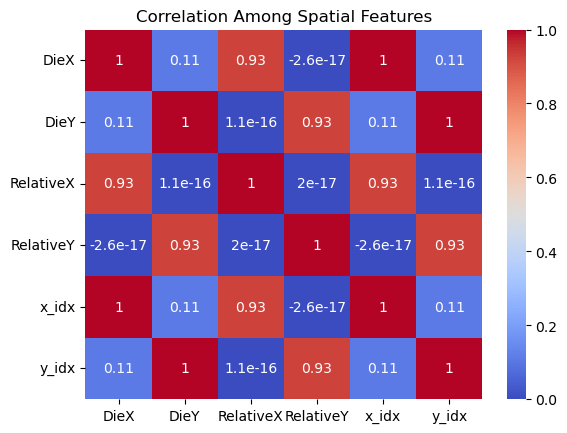

In [12]:
spatial_features = ['DieX', 'DieY', 'RelativeX', 'RelativeY', 'x_idx', 'y_idx']
sns.heatmap(train_data_engineered[spatial_features].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Among Spatial Features")
plt.show()

We can see DieX, x_idx and RelativeX are highly correlated, Which was to be expected.  
We dont need all features. The same goes for DieY, y_idx and RelativeY.  
Lets drop DieX, DieY, x_idx and y_idx features as we have their Normelized values which might be better for machine learning.

In [13]:
train_data_engineered = train_data_engineered.drop(columns=['DieX','DieY','x_idx', 'y_idx'])
test_data_engineered = test_data_engineered.drop(columns=['DieX','DieY','x_idx', 'y_idx'])

### Feature correlation map 

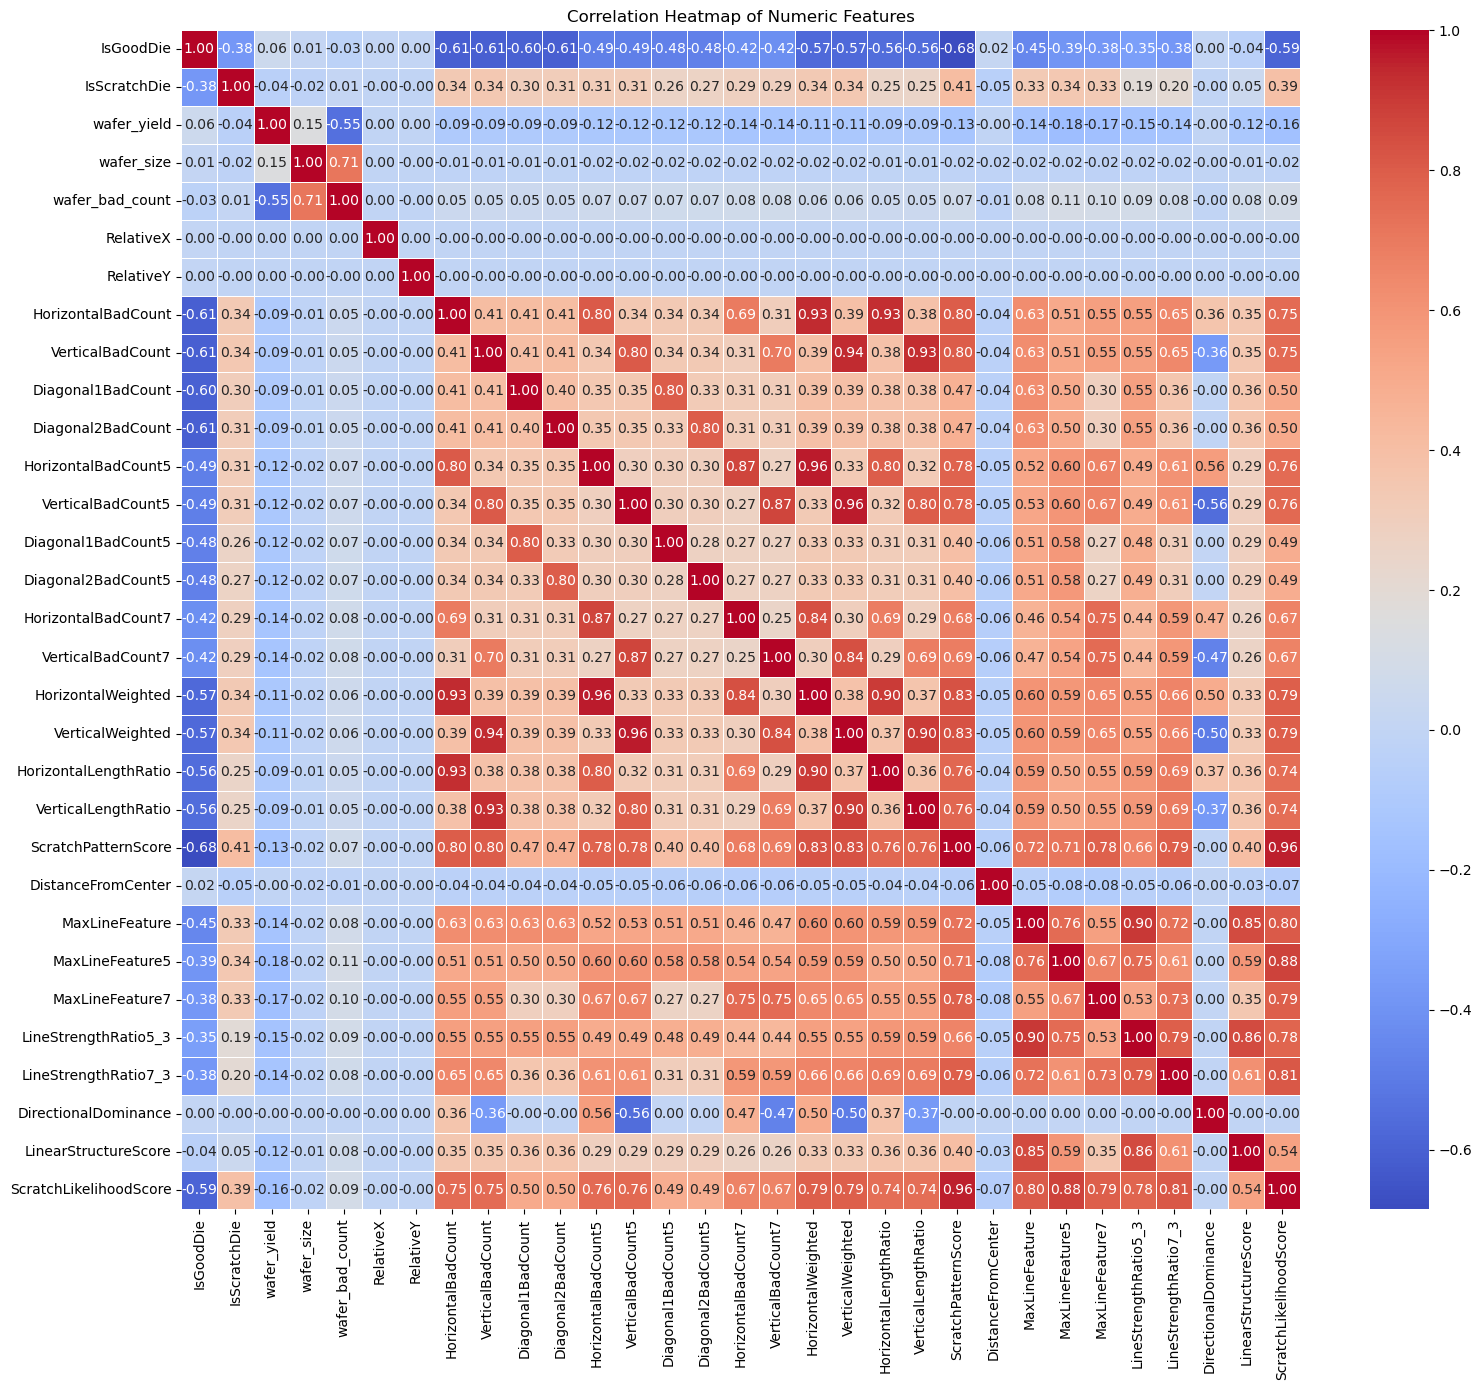

In [14]:
# Convert boolean columns to integers (0 and 1)
train_data_engineered['IsGoodDie'] = train_data_engineered['IsGoodDie'].astype(int)
train_data_engineered['IsScratchDie'] = train_data_engineered['IsScratchDie'].astype(int)

# Select numeric features only
numeric_features = train_data_engineered.select_dtypes(include=np.number)

# Calculate the correlation matrix
correlation_matrix = numeric_features.corr()

# Handle potential NaN values
correlation_matrix = correlation_matrix.fillna(0)

# Create the heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()
plt.show()

## Feature Selection  
Let's use Feature selection to narrow down the best features to use during training and predictions.

In [15]:
# Subsampling Wafers
# Number of wafers to select for subsampling
n_selected_wafers = 1000
np.random.seed(42)
selected_wafers = np.random.choice(
    train_data_engineered['WaferName'].unique(),
    size=n_selected_wafers,
    replace=False
)
df_train_subsample = train_data_engineered[
    train_data_engineered['WaferName'].isin(selected_wafers)
].copy()

# Feature Selection on Subsample
# Target variable (y) for the subsample
y_subsample = df_train_subsample['IsScratchDie'].astype(int)

# Features (X) for the subsample
X_subsample = df_train_subsample.drop(columns=['WaferName', 'IsScratchDie'])

# Fit RandomForestClassifier on the subsample
rf = RandomForestClassifier(
    n_estimators=100, random_state=42, n_jobs=-1
)
rf.fit(X_subsample, y_subsample)

# Select features with importance above the threshold
selector = SelectFromModel(
    rf, threshold="mean", prefit=True
)
X_subsample_reduced = selector.transform(X_subsample)
selected_features = X_subsample.columns[selector.get_support()]

print("Selected Features:")
print(selected_features)

Selected Features:
Index(['wafer_yield', 'wafer_bad_count', 'RelativeX', 'RelativeY',
       'ScratchPatternScore', 'DistanceFromCenter', 'MaxLineFeature',
       'MaxLineFeature5', 'MaxLineFeature7', 'ScratchLikelihoodScore'],
      dtype='object')


## Selected feature correlation map  
Let's check how correlated are the features that were selected  
We can also see that 'wafer_yield' was selected but we might not want that in our scratch prediction since this is a wafer level feature and not related to a specific die.   
In the meantime we will keep it since we'll need it to filter over low yield wafers. 

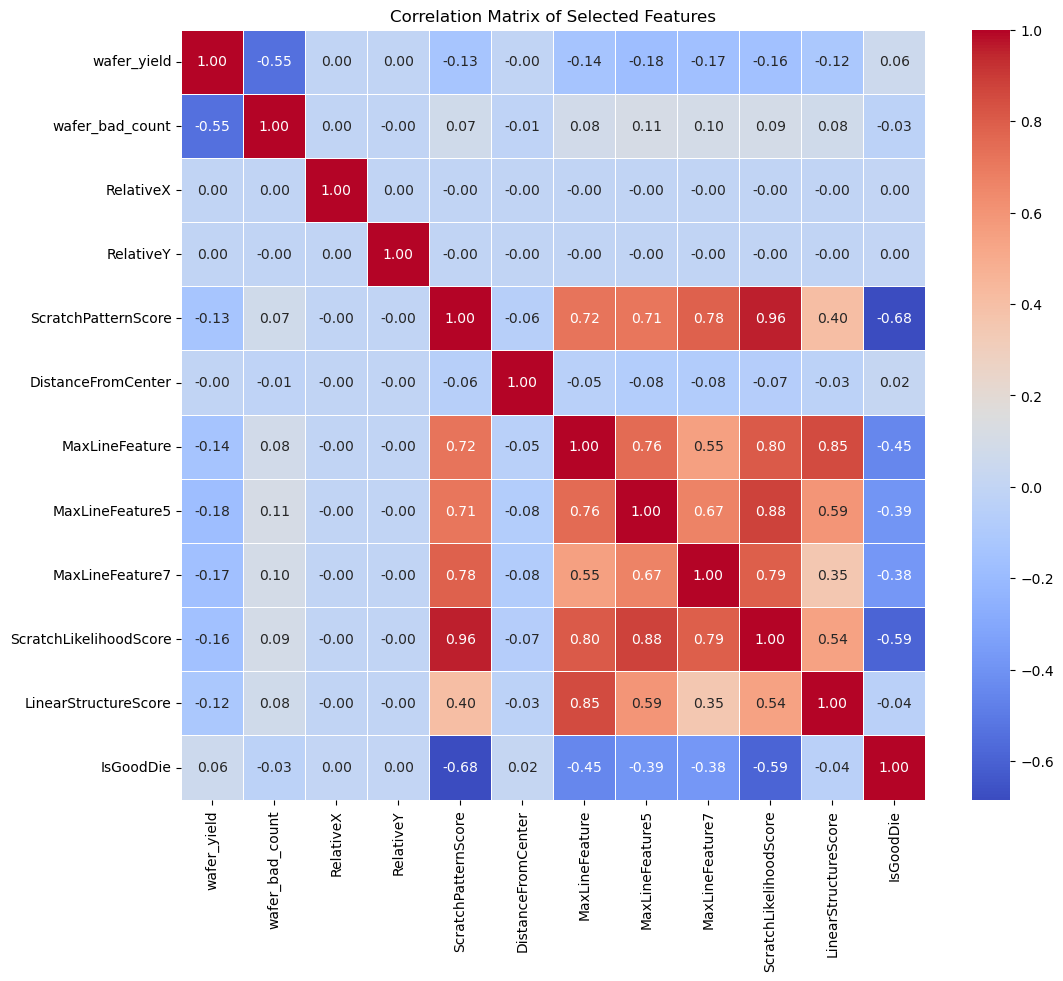


Highly Correlated Feature Pairs (Absolute Correlation > 0.8):
(ScratchLikelihoodScore, ScratchPatternScore): 0.96
(ScratchLikelihoodScore, MaxLineFeature): 0.80
(ScratchLikelihoodScore, MaxLineFeature5): 0.88
(LinearStructureScore, MaxLineFeature): 0.85


In [16]:
features_to_keep = [
    'wafer_yield', # Kept for low yield filtering purposes
    'wafer_bad_count',
    'RelativeX',
    'RelativeY',
    'ScratchPatternScore',
    'DistanceFromCenter',
    'MaxLineFeature',
    'MaxLineFeature5',
    'MaxLineFeature7',
    'ScratchLikelihoodScore',
    'LinearStructureScore', # Although it wasnt selected, it is useful to keep based on correlation to target
    'IsGoodDie' # Although it wasnt selected, it is useful to keep based on correlation to target
]

# Select only the features we want to check for correlations
correlation_data = train_data_engineered[features_to_keep]

# Calculate the correlation matrix
correlation_matrix = correlation_data.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Selected Features')
plt.show()

# Identify highly correlated pairs (in our case, absolute correlation > 0.8)
threshold = 0.8
highly_correlated = []
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
for column in upper.columns:
    highly_correlated_cols = [index for index in upper.index[abs(upper[column]) > threshold]]
    if highly_correlated_cols:
        highly_correlated.append((column, highly_correlated_cols))

print("\nHighly Correlated Feature Pairs (Absolute Correlation > {}):".format(threshold))
if highly_correlated:
    for pair in highly_correlated:
        feature1 = pair[0]
        for feature2 in pair[1]:
            print(f"({feature1}, {feature2}): {correlation_matrix.loc[feature1, feature2]:.2f}")
else:
    print("No highly correlated feature pairs found above the threshold.")

These highly correlated features are to be expected since 'ScratchLikelihoodScore' and 'LinearStructureScore' are combinations of other features (those that they are highly correlated with).  
So it might still be useful to keep them all for now.

## Prepering datasets with selected features

In [17]:
# List of features to keep for model training
features_to_keep = [
    'WaferName', # Added for the purpuse of wafer grouping and filtering later on, will be removed before training and other predictions
    'wafer_yield', # Might decide to remove later on
    'wafer_bad_count',
    'RelativeX',
    'RelativeY',
    'ScratchPatternScore',
    'DistanceFromCenter',
    'MaxLineFeature',
    'MaxLineFeature5',
    'MaxLineFeature7',
    'ScratchLikelihoodScore',
    'LinearStructureScore',
    'IsGoodDie'
]

train_data_model = train_data_engineered[features_to_keep].copy()
test_data_model = test_data_engineered[features_to_keep].copy()

print("Shape of training data for model:", train_data_model.shape)
print("Features kept for training:", train_data_model.columns.tolist())

Shape of training data for model: (10415400, 13)
Features kept for training: ['WaferName', 'wafer_yield', 'wafer_bad_count', 'RelativeX', 'RelativeY', 'ScratchPatternScore', 'DistanceFromCenter', 'MaxLineFeature', 'MaxLineFeature5', 'MaxLineFeature7', 'ScratchLikelihoodScore', 'LinearStructureScore', 'IsGoodDie']


## Basic model prediction  
### **Why LightGBM?**  
We chose LightGBM because it efficiently handles large, tabular datasets like wafer inspection data. It performs well with both numerical and categorical features and is particularly strong on datasets with class imbalance, which is crucial for detecting wafer scratches. This enables the model to focus on identifying defect patterns effectively.

### **Why F1 Score?**  
The F1 score balances precision and recall, which is key for our task. We aim to detect as many true scratches as possible (high recall) while minimizing false alarms (high precision). The F1 score offers a more reliable measure of this balance than accuracy alone.

In [18]:
target_col = 'IsScratchDie'
wafer_col = 'WaferName'

def wafer_aware_split(df, target_col, group_col, test_size=0.2, random_state=42):
    """Split data while keeping groups (wafers) together"""
    if group_col not in df.columns:
        raise ValueError(f"Group column '{group_col}' not found in DataFrame")
    
    splitter = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_idx, test_idx = next(splitter.split(df, df[target_col], df[group_col]))
    return df.iloc[train_idx], df.iloc[test_idx]

# Split the data into training and validation sets while keeping wafers together
train_data_split, val_data_split = wafer_aware_split(
    train_data_engineered,
    target_col='IsScratchDie',
    group_col='WaferName',
    test_size=0.2
)

# Print split information
print(f"Total wafers: {train_data_engineered[wafer_col].nunique()}")
print(f"Training wafers: {train_data_split[wafer_col].nunique()}")
print(f"Validation wafers: {val_data_split[wafer_col].nunique()}")

print(f"\nTotal samples: {len(train_data_engineered)}")
print(f"Training samples: {len(train_data_split)} ({len(train_data_split)/len(train_data_engineered):.1%})")
print(f"Validation samples: {len(val_data_split)} ({len(val_data_split)/len(train_data_engineered):.1%})")

# Extract features and targets
X_train = train_data_split[features_to_keep].drop(wafer_col, axis=1)
y_train = train_data_split[target_col].astype(int)

X_val = val_data_split[features_to_keep].drop(wafer_col, axis=1)
y_val = val_data_split[target_col].astype(int)

# Train the LightGBM model
print("\nTraining LightGBM model...")
model = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=8,
    num_leaves=31,
    random_state=42,
    class_weight='balanced'
)

model = lgb.LGBMClassifier()  # Initialize the model
model.fit(X_train, y_train)

# Predict on validation set
y_val_pred = model.predict(X_val)

# Evaluate
val_f1 = f1_score(y_val, y_val_pred)
print("\nValidation Results:")
print(f"F1 Score: {val_f1:.4f}")

# Confusion Matrix
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:")
    print(pd.DataFrame(
        cm,
        columns=['Predicted Not Scratch', 'Predicted Scratch'],
        index=['Actual Not Scratch', 'Actual Scratch']
    ))

print_confusion_matrix(y_val, y_val_pred)


Total wafers: 4200
Training wafers: 3360
Validation wafers: 840

Total samples: 10415400
Training samples: 8357476 (80.2%)
Validation samples: 2057924 (19.8%)

Training LightGBM model...
[LightGBM] [Info] Number of positive: 64964, number of negative: 8292512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.321190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1300
[LightGBM] [Info] Number of data points in the train set: 8357476, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007773 -> initscore=-4.849275
[LightGBM] [Info] Start training from score -4.849275

Validation Results:
F1 Score: 0.7349

Confusion Matrix:
                    Predicted Not Scratch  Predicted Scratch
Actual Not Scratch                2039978               2591
Actual Scratch                       4929              10426


We got a decent F1 score of 0.7349. Now, lets try to use hyperparameter tuning to see if we can improve our predictions on top of that.

## Note!  
This next part in all in one cell since I encountered a problem where after you run a computationally heavy tast such as hyperparameter tuning, after this cell finished the jupyter notebook is unable to run any other cells. They all get stuck on "pending".  
Because of that, I had to put the entire next part of code all in one cell so the entire code would manage to run. 

This next cell includes the following:  
- configuration - defines constants
- Group-based train/validation splitting function
- Actual splitting of data into train and validation sets
- Analysis of scratch distribution in wafers
- Function to filter by yield
- Feature preparation and target variable definition
- Function to sample wafers for training
- Optuna objective function for hyperparameter optimization
- Running the Optuna hyperparameter search
- Training the top models for the ensemble
- Defining the ensemble prediction function
- Validation of the ensemble model performance
- Test data preparation
- Test prediction generation
- Statistics calculation for test predictions
- Final output preparation
- Final validation, export of results for submission

In [19]:
# === CONFIG ===
WAFER_YIELD_THRESHOLD = 0.92  # Wafers with yield below this are filtered out
N_TOP_MODELS = 15           # Number of top models in ensemble
N_TRIALS = 30              # Number of hyperparameter optimization trials
RANDOM_SEED = 42           # Random seed for reproducibility
CLASS_WEIGHT = 15          # Weight for the minority class
MAX_WAFERS_PER_TRIAL = 330  # Maximum number of wafers to use per training run
ENSEMBLE_VOTE_THRESHOLD = 0.4  # Fraction of models needed to classify as scratch

# === TIMING ===
start_time = time.time()

# === GROUP-BASED TRAIN/VAL SPLITTING ===
print("Performing wafer-wise train/validation splitting...")

def group_train_test_split(df, target_col, group_col, test_size=0.2, random_state=42):
    """Split data while keeping groups (wafers) together"""
    if group_col not in df.columns:
        raise ValueError(f"Group column '{group_col}' not found in DataFrame")
    
    splitter = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_idx, test_idx = next(splitter.split(df, df[target_col], df[group_col]))
    return df.iloc[train_idx], df.iloc[test_idx]

# Split into train and validation sets
train_data_split, val_data_split = group_train_test_split(
    train_data_engineered,
    target_col='IsScratchDie',
    group_col='WaferName',
    test_size=0.2
)

# Print information about the split
print(f"Train wafers: {train_data_split['WaferName'].nunique()}, Validation wafers: {val_data_split['WaferName'].nunique()}")

# Print class distribution
print("Train data class distribution:")
print(train_data_split['IsScratchDie'].value_counts(normalize=True).apply(lambda x: f"{x:.2%}"))

print("Validation data class distribution:")
print(val_data_split['IsScratchDie'].value_counts(normalize=True).apply(lambda x: f"{x:.2%}"))

print(f"Train data size: {len(train_data_split)}, Validation data size: {len(val_data_split)}")

# === ANALYZE SCRATCH DISTRIBUTION ===
print("\nAnalyzing scratch distribution in wafers...")
# Count scratches per wafer
scratch_stats = train_data_split.groupby('WaferName')['IsScratchDie'].agg(['mean', 'sum', 'count'])
scratch_stats.columns = ['scratch_ratio', 'scratch_count', 'die_count']

# === YIELD FILTERING ===
print("\nApplying yield filtering...")

def filter_by_yield(X_df, y_series, threshold):
    """Filter out wafers with yield below threshold"""
    if 'wafer_yield' not in X_df.columns:
        print("WARNING: wafer_yield not in features, skipping yield filtering")
        return X_df, y_series
    
    if 'WaferName' not in X_df.columns:
        print("WARNING: WaferName not in features, skipping yield filtering")
        return X_df, y_series
    
    # Group by wafer and get the yield
    wafer_yields = X_df.groupby('WaferName')['wafer_yield'].first()
    
    # Count wafers before filtering
    total_wafers = len(wafer_yields)
    
    # Identify wafers to keep
    valid_wafers = wafer_yields[wafer_yields >= threshold].index
    
    # Count wafers after filtering
    valid_wafer_count = len(valid_wafers)
    
    # Filter data
    if valid_wafer_count > 0:
        filtered_mask = X_df['WaferName'].isin(valid_wafers)
        X_filtered = X_df[filtered_mask].copy()
        y_filtered = y_series[filtered_mask].copy()
        print(f"  - Removed {total_wafers - valid_wafer_count} wafers with yield < {threshold}")
        print(f"  - Keeping {valid_wafer_count} wafers with yield >= {threshold}")
        print(f"  - Removed {len(X_df) - len(X_filtered)} dies, keeping {len(X_filtered)} dies")
        return X_filtered, y_filtered
    else:
        print(f"WARNING: No wafers with yield >= {threshold}, skipping filtering")
        return X_df, y_series

# === TARGET AND FEATURES ===
# Make sure WaferName is included for wafer group handling
if 'WaferName' not in features_to_keep:
    features_to_keep.append('WaferName')
if 'wafer_yield' not in features_to_keep:
    features_to_keep.append('wafer_yield')

# Store the model features separately - this is important!
model_features = [f for f in features_to_keep if f != 'WaferName' and f != 'wafer_yield'] # Removed wafer_yield as well like mentioned at the feature selection section

# Prepare data for training
X_train = train_data_split[features_to_keep].copy()
y_train = train_data_split['IsScratchDie'].astype(int)

X_val = val_data_split[features_to_keep].copy()
y_val = val_data_split['IsScratchDie'].astype(int)

# Apply yield filtering
print("Before filtering - Train wafers:", X_train['WaferName'].nunique(), "dies:", len(X_train))
print("Before filtering - Val wafers:", X_val['WaferName'].nunique(), "dies:", len(X_val))

X_train, y_train = filter_by_yield(X_train, y_train, WAFER_YIELD_THRESHOLD)
X_val, y_val = filter_by_yield(X_val, y_val, WAFER_YIELD_THRESHOLD)

print("After filtering - Train wafers:", X_train['WaferName'].nunique(), "dies:", len(X_train))
print("After filtering - Val wafers:", X_val['WaferName'].nunique(), "dies:", len(X_val))

# === Helper: Sample random wafers with all their dies ===
def sample_wafers_for_training(df, num_wafers=None, seed=None):
    """Randomly sample a fixed number of full wafers (with all dies)."""
    if num_wafers is None:
        num_wafers = MAX_WAFERS_PER_TRIAL
        
    unique_wafers = df['WaferName'].unique()
    rng = np.random.default_rng(seed)
    selected_wafers = rng.choice(unique_wafers, size=min(num_wafers, len(unique_wafers)), replace=False)
    return df[df['WaferName'].isin(selected_wafers)].copy()

# === OPTUNA OBJECTIVE ===
def objective(trial):
    # Random seed for this trial
    trial_seed = random.randint(1, 10000)
    random.seed(trial_seed)

    # Sample wafers from already yield-filtered X_train
    trial_train_data = sample_wafers_for_training(
        pd.concat([X_train, y_train], axis=1), 
        num_wafers=MAX_WAFERS_PER_TRIAL, 
        seed=trial_seed
    )
    
    X_trial = trial_train_data[features_to_keep]
    y_trial = trial_train_data['IsScratchDie'].astype(int)
    
    print(f"\nTrial {trial.number}: Sampled {X_trial['WaferName'].nunique()} wafers, {len(X_trial)} dies")

    # LightGBM Hyperparameters
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 80),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 50, 300),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.5, 30.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 30.0, log=True),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.05, 1.0, log=True),
        'scale_pos_weight': CLASS_WEIGHT,
        'verbosity': -1,
        'seed': trial_seed,
        'num_threads': 1,
        'bagging_freq': 5,
    }

    # Create datasets for training
    dtrain = lgb.Dataset(X_trial[model_features], label=y_trial)
    dvalid = lgb.Dataset(X_val[model_features], label=y_val)

    model = lgb.train(
        params,
        dtrain,
        valid_sets=[dvalid],
        num_boost_round=500,
        callbacks=[
            early_stopping(25),
            log_evaluation(0)
        ]
    )

    # Predict on validation set
    preds = model.predict(X_val[model_features], num_iteration=model.best_iteration)

    # Try different probability thresholds
    thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
    best_f1 = 0
    best_threshold = 0.5

    for threshold in thresholds:
        preds_binary = (preds >= threshold).astype(int)
        current_f1 = f1_score(y_val, preds_binary)
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = threshold

    trial.set_user_attr("threshold", best_threshold)

    print(f"Trial {trial.number} - F1 Score: {best_f1:.4f} (threshold: {best_threshold})")
    return best_f1

# === RUN OPTUNA STUDY ===
print("\nStarting Optuna hyperparameter optimization...")
sampler = optuna.samplers.TPESampler(n_startup_trials=5, seed=RANDOM_SEED)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=N_TRIALS, n_jobs=2, show_progress_bar=True)

# === TRAIN TOP MODELS ===
# Sort trials by their F1 score
top_trials = sorted(study.trials, key=lambda t: t.value, reverse=True)[:N_TOP_MODELS]
top_models = []
top_thresholds = []

print(f"\nTraining final {N_TOP_MODELS} models for ensemble...")

# For each top trial, create a model with random sampling of wafers
for i, trial in enumerate(top_trials):
    print(f"Training model {i + 1}, F1 score: {trial.value:.4f}")
    
    # Get trial-specific parameters
    trial_seed = random.randint(1, 10000)
    random.seed(trial_seed)
    
    # Get optimal threshold for this model
    if "threshold" in trial.user_attrs:
        optimal_threshold = trial.user_attrs["threshold"]
        top_thresholds.append(optimal_threshold)
    else:
        # Default threshold
        optimal_threshold = 0.5
        top_thresholds.append(optimal_threshold)
    
    # Sample wafers from already yield-filtered X_train
    trial_train_data = sample_wafers_for_training(
        pd.concat([X_train, y_train], axis=1),
        num_wafers=MAX_WAFERS_PER_TRIAL,
        seed=trial_seed
    )
    
    X_trial = trial_train_data[features_to_keep]
    y_trial = trial_train_data['IsScratchDie'].astype(int)
    
    print(f"Model {i+1}: Sampled {X_trial['WaferName'].nunique()} wafers, {len(X_trial)} dies")
    
    # Create datasets for training
    dtrain = lgb.Dataset(X_trial[model_features], label=y_trial)
    dvalid = lgb.Dataset(X_val[model_features], label=y_val)
    
    # Apply the trial parameters
    params = trial.params.copy()
    params['seed'] = trial_seed
    
    # Train model
    model = lgb.train(
        params,
        dtrain,
        valid_sets=[dvalid],
        num_boost_round=500,
        callbacks=[
            early_stopping(25),
            log_evaluation(0)
        ]
    )
    
    # Add to ensemble
    top_models.append(model)

# === ENSEMBLE PREDICTION FUNCTION ===
def ensemble_predict(models, data, thresholds=None):
    """
    Generate ensemble predictions with proper wafer yield filtering
    and detailed debug information
    """
    # Create a copy to avoid modifying original data
    data_copy = data.copy()
    
    # Initialize predictions array (default all to 0)
    ensemble_preds = np.zeros(len(data_copy), dtype=int)
    
    # First identify low-yield wafers
    low_yield_wafers = set()
    low_yield_die_count = 0
    
    if 'wafer_yield' in data_copy.columns and 'WaferName' in data_copy.columns:
        # Group by wafer and get yield values
        wafer_yields = data_copy.groupby('WaferName')['wafer_yield'].first()
        
        # Find low yield wafers (strictly less than threshold)
        low_yield_wafers = set(wafer_yields[wafer_yields < WAFER_YIELD_THRESHOLD].index)
        
        # Count dies in low yield wafers
        if low_yield_wafers:
            low_yield_die_count = data_copy[data_copy['WaferName'].isin(low_yield_wafers)].shape[0]
            print(f"Found {len(low_yield_wafers)} wafers with yield < {WAFER_YIELD_THRESHOLD} containing {low_yield_die_count} dies")
    
    # Create mask for normal-yield wafers (those we'll predict on)
    if low_yield_wafers and 'WaferName' in data_copy.columns:
        normal_yield_mask = ~data_copy['WaferName'].isin(low_yield_wafers)
        print(f"Will predict for {normal_yield_mask.sum()} dies in {len(wafer_yields) - len(low_yield_wafers)} normal-yield wafers")
    else:
        normal_yield_mask = np.ones(len(data_copy), dtype=bool)
        print(f"Will predict for all {len(data_copy)} dies (no yield filtering)")
    
    # Only proceed with prediction if we have dies to predict on
    if normal_yield_mask.sum() > 0:
        # Use default thresholds if not provided
        if thresholds is None:
            thresholds = [0.5] * len(models)
        
        # Generate individual model predictions
        all_preds = []
        model_binary_counts = []
        
        print(f"Using {len(models)} models for ensemble prediction")
        
        for i, (model, threshold) in enumerate(zip(models, thresholds)):
            # Get model predictions using only model features
            try:
                # Extract only the features used by the model
                prediction_features = data_copy.loc[normal_yield_mask, model_features]
                
                # Check for missing values
                if prediction_features.isna().any().any():
                    print(f"WARNING: Model {i}: Input data contains NaN values - filling with 0")
                    prediction_features = prediction_features.fillna(0)
                
                # Make predictions
                model_preds = model.predict(prediction_features)
                
                # Convert to binary predictions
                binary_preds = (model_preds >= threshold).astype(int)
                all_preds.append(binary_preds)
                
                # Track predictions from this model
                model_binary_counts.append(binary_preds.sum())
                print(f"  Model {i}: predicted {binary_preds.sum()} scratched dies with threshold {threshold:.2f}")
                
            except Exception as e:
                print(f"ERROR in Model {i}: {str(e)}")
                # Skip this model
                continue
        
        # Combine predictions with voting
        if all_preds:
            # For each die, count how many models predict scratch
            vote_counts = np.stack(all_preds, axis=1).sum(axis=1)
            
            # Use threshold voting - a die is scratched if at least threshold fraction of models say so
            threshold_votes = len(models) * ENSEMBLE_VOTE_THRESHOLD
            normal_yield_preds = (vote_counts >= threshold_votes).astype(int)
            
            # Assign predictions to normal yield wafers
            ensemble_preds[normal_yield_mask] = normal_yield_preds
            
            print(f"Ensemble predicted {normal_yield_preds.sum()} scratched dies out of {len(normal_yield_preds)} in normal-yield wafers")
            
            # Print distribution of votes
            vote_dist = np.bincount(vote_counts, minlength=len(models)+1)
            for vote_count, count in enumerate(vote_dist):
                if count > 0:
                    print(f"  {count} dies had {vote_count}/{len(models)} models voting for scratch")
        else:
            print("WARNING: No valid model predictions! Setting all normal-yield predictions to 0")
    
    # Verify final predictions
    scratch_count = ensemble_preds.sum()
    total_count = len(ensemble_preds)
    print(f"Final predictions: {scratch_count} scratched dies out of {total_count} ({scratch_count/total_count:.2%})")
    
    # If we have wafer names, check distribution by wafer
    if 'WaferName' in data_copy.columns:
        # Create temp dataframe for analysis
        temp_df = pd.DataFrame({
            'WaferName': data_copy['WaferName'],
            'Prediction': ensemble_preds
        })
        
        # Count wafers with at least one scratch prediction
        wafers_with_scratches = temp_df.groupby('WaferName')['Prediction'].sum()
        scratch_wafer_count = (wafers_with_scratches > 0).sum()
        total_wafer_count = len(wafers_with_scratches)
        
        print(f"Wafers with scratches: {scratch_wafer_count} out of {total_wafer_count} ({scratch_wafer_count/total_wafer_count:.2%})")
    
    return ensemble_preds

# === VALIDATION EVALUATION ===
print("\nEvaluating ensemble on validation data...")
val_preds = ensemble_predict(top_models, X_val, top_thresholds)
val_f1 = f1_score(y_val, val_preds)
print(f"Validation F1 Score (Ensemble): {val_f1:.4f}")

# Print confusion matrix
cm = confusion_matrix(y_val, val_preds)
print("\nConfusion Matrix:")
print(pd.DataFrame(cm, columns=['Predicted Not Scratch', 'Predicted Scratch'],
                 index=['Actual Not Scratch', 'Actual Scratch']))

# === TEST SET PREDICTION SECTION ===
print("\nGenerating predictions for test data...")

# Ensure test_data_model has the same features as we used for training
test_data = test_data_model.copy()

# Make sure test data has WaferName for grouping
if 'WaferName' not in test_data.columns:
    if 'WaferName' in df_wafers.columns:
        test_data['WaferName'] = df_wafers['WaferName']
    else:
        print("ERROR: WaferName not found in test data or df_wafers!")
        # Create a fallback column if absolutely necessary
        test_data['WaferName'] = [f"Unknown_wafer_{i//1000}" for i in range(len(test_data))]

# Ensure we have wafer_yield for low-yield filtering
if 'wafer_yield' not in test_data.columns:
    if 'wafer_yield' in df_wafers.columns:
        test_data['wafer_yield'] = df_wafers['wafer_yield']
    else:
        print("WARNING: wafer_yield not found in test data or df_wafers!")
        # Set a default yield above threshold to avoid filtering
        test_data['wafer_yield'] = 1.0

# Ensure all model features are present
missing_features = [f for f in model_features if f not in test_data.columns]
if missing_features:
    print(f"WARNING: Missing features in test data: {missing_features}")
    for feature in missing_features:
        test_data[feature] = 0

# Generate predictions using our ensemble
print("Running ensemble prediction...")
test_preds = ensemble_predict(top_models, test_data, top_thresholds)

# === CALCULATE STATISTICS FOR TEST PREDICTIONS ===
# We need to track which wafers were excluded due to low yield
# First identify low-yield wafers
low_yield_wafers = set()
if 'wafer_yield' in test_data.columns:
    wafer_yields = test_data.groupby('WaferName')['wafer_yield'].first()
    low_yield_wafers = set(wafer_yields[wafer_yields < WAFER_YIELD_THRESHOLD].index)
    print(f"Low yield wafers excluded from prediction: {len(low_yield_wafers)}")

# Create a DataFrame for analysis with prediction results
test_results = pd.DataFrame({
    'WaferName': test_data['WaferName'],
    'Prediction': test_preds
})

# Compute wafer-level statistics
wafer_stats = test_results.groupby('WaferName').agg(
    scratch_count=('Prediction', 'sum'),
    die_count=('Prediction', 'count'),
    scratch_ratio=('Prediction', lambda x: x.sum() / len(x) * 100)
).sort_values('scratch_ratio', ascending=False)

print("\nTop 10 wafers by scratch percentage:")
print(wafer_stats.head(10))

# Count wafers with at least one scratch
scratch_wafers_test = wafer_stats[wafer_stats['scratch_count'] > 0].shape[0]
total_wafers_test = wafer_stats.shape[0]
print(f"\nTest data: {scratch_wafers_test} out of {total_wafers_test} wafers have scratches ({scratch_wafers_test/total_wafers_test:.2%})")

# Compare with training data
scratch_wafers_train = scratch_stats[scratch_stats['scratch_count'] > 0].shape[0]
total_wafers_train = scratch_stats.shape[0]
print(f"Train data: {scratch_wafers_train} out of {total_wafers_train} wafers have scratches ({scratch_wafers_train/total_wafers_train:.2%})")

# CRITICAL FIX: Ensure we correctly transfer predictions to df_wafers_test

# Initialize IsScratchDie column in df_wafers_test to 0
df_wafers_test['IsScratchDie'] = 0

# Create a mapping from wafer name and die position to prediction
test_data['die_id'] = test_data.groupby('WaferName').cumcount()
prediction_map = dict(zip(zip(test_data['WaferName'], test_data['die_id']), test_preds))

# Add die_id to df_wafers_test
df_wafers_test['die_id'] = df_wafers_test.groupby('WaferName').cumcount()

# Apply predictions from mapping
for i, row in df_wafers_test.iterrows():
    key = (row['WaferName'], row['die_id'])
    if key in prediction_map:
        df_wafers_test.at[i, 'IsScratchDie'] = prediction_map[key]

# Cleanup
df_wafers_test.drop('die_id', axis=1, inplace=True)

# CRITICAL FIX: Make sure low yield wafers have prediction = 0
# This ensures consistency with our ensemble_predict function
if low_yield_wafers:
    mask = df_wafers_test['WaferName'].isin(low_yield_wafers)
    df_wafers_test.loc[mask, 'IsScratchDie'] = 0
    print(f"Reset predictions to 0 for {mask.sum()} dies in {len(low_yield_wafers)} low-yield wafers")

# Verify final predictions in df_wafers_test
scratch_count = df_wafers_test['IsScratchDie'].sum()
total_count = len(df_wafers_test)
print(f"\nFinal predictions in df_wafers_test: {scratch_count} scratched dies out of {total_count} ({scratch_count/total_count:.2%})")

# Verify wafer-level predictions
wafer_scratch_count = df_wafers_test.groupby('WaferName')['IsScratchDie'].sum()
wafers_with_scratches = (wafer_scratch_count > 0).sum()
total_wafers = len(wafer_scratch_count)
print(f"Wafers with scratches: {wafers_with_scratches} out of {total_wafers} ({wafers_with_scratches/total_wafers:.2%})")

# === Save the final output and create submission ===
name = 'Itay Chabra'
email = 'itaychabra@gmail.com'

date_str = datetime.now().strftime('%Y%m%d')
filename = f"{date_str}_{name}_{email}_df_wafers_test_with_preds.csv"
df_wafers_test.to_csv(filename, index=False)
print("Saved file:", filename)

Performing wafer-wise train/validation splitting...
Train wafers: 3360, Validation wafers: 840
Train data class distribution:
IsScratchDie
0    99.22%
1     0.78%
Name: proportion, dtype: object
Validation data class distribution:
IsScratchDie
0    99.25%
1     0.75%
Name: proportion, dtype: object
Train data size: 8357476, Validation data size: 2057924

Analyzing scratch distribution in wafers...

Applying yield filtering...
Before filtering - Train wafers: 3360 dies: 8357476
Before filtering - Val wafers: 840 dies: 2057924
  - Removed 1 wafers with yield < 0.92
  - Keeping 3359 wafers with yield >= 0.92
  - Removed 1513 dies, keeping 8355963 dies
  - Removed 1 wafers with yield < 0.92
  - Keeping 839 wafers with yield >= 0.92
  - Removed 1005 dies, keeping 2056919 dies


[I 2025-05-04 20:19:04,525] A new study created in memory with name: no-name-c730d916-3141-44dd-9304-d6bf9be9cd30


After filtering - Train wafers: 3359 dies: 8355963
After filtering - Val wafers: 839 dies: 2056919

Starting Optuna hyperparameter optimization...


  0%|          | 0/30 [00:00<?, ?it/s]


Trial 0: Sampled 330 wafers, 813250 dies

Trial 1: Sampled 330 wafers, 840890 dies
Training until validation scores don't improve for 25 rounds
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[25]	valid_0's binary_logloss: 0.0211737
Trial 0 - F1 Score: 0.6929 (threshold: 0.4)
[I 2025-05-04 20:19:16,573] Trial 0 finished with value: 0.6929057058435412 and parameters: {'learning_rate': 0.023525479889801713, 'num_leaves': 35, 'max_depth': 9, 'min_child_samples': 140, 'reg_alpha': 1.7228533764339549, 'reg_lambda': 0.717187955256399, 'min_split_gain': 0.45137930388770486}. Best is trial 0 with value: 0.6929057058435412.

Trial 2: Sampled 330 wafers, 801086 dies
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.0210925
Trial 1 - F1 Score: 0.6908 (threshold: 0.4)
[I 2025-05-04 20:19:22,053] Trial 1 finished with value: 0.6908254744440564 and parameters: {'learning_ra

In [8]:
import pandas as pd

# Load test dataset predictions CSV file
file_path = "20250504_Itay Chabra_itaychabra@gmail.com_df_wafers_test_with_preds.csv"
df = pd.read_csv(file_path)

# Count the total number of dies
total_dies = len(df)
print(f"Total number of dies: {total_dies}")

# Count the number of scratched dies
scratched_dies = df['IsScratchDie'].sum()  # Assuming True/False, True is treated as 1
print(f"Number of scratched dies: {scratched_dies}")

# Calculate the percentage of scratched dies
percentage_scratched_dies = (scratched_dies / total_dies) * 100
print(f"Percentage of scratched dies: {percentage_scratched_dies:.2f}%")

# --- Stats on Scratched Wafers ---

# Group by WaferName and check if any die in that wafer is scratched
scratched_wafers_series = df.groupby('WaferName')['IsScratchDie'].any()

# Count the number of scratched wafers
number_scratched_wafers = scratched_wafers_series.sum()
print(f"\nNumber of scratched wafers: {number_scratched_wafers}")

# Count the total number of wafers
total_wafers = scratched_wafers_series.count()
print(f"Total number of wafers: {total_wafers}")

# Calculate the percentage of scratched wafers
percentage_scratched_wafers = (number_scratched_wafers / total_wafers) * 100
print(f"Percentage of scratched wafers: {percentage_scratched_wafers:.2f}%")

Total number of dies: 1128335
Number of scratched dies: 8676
Percentage of scratched dies: 0.77%

Number of scratched wafers: 356
Total number of wafers: 455
Percentage of scratched wafers: 78.24%


Using the fuction provided to us at the beginning of this assignment, lets try to plot our predictions on the test dataset and see how we did:

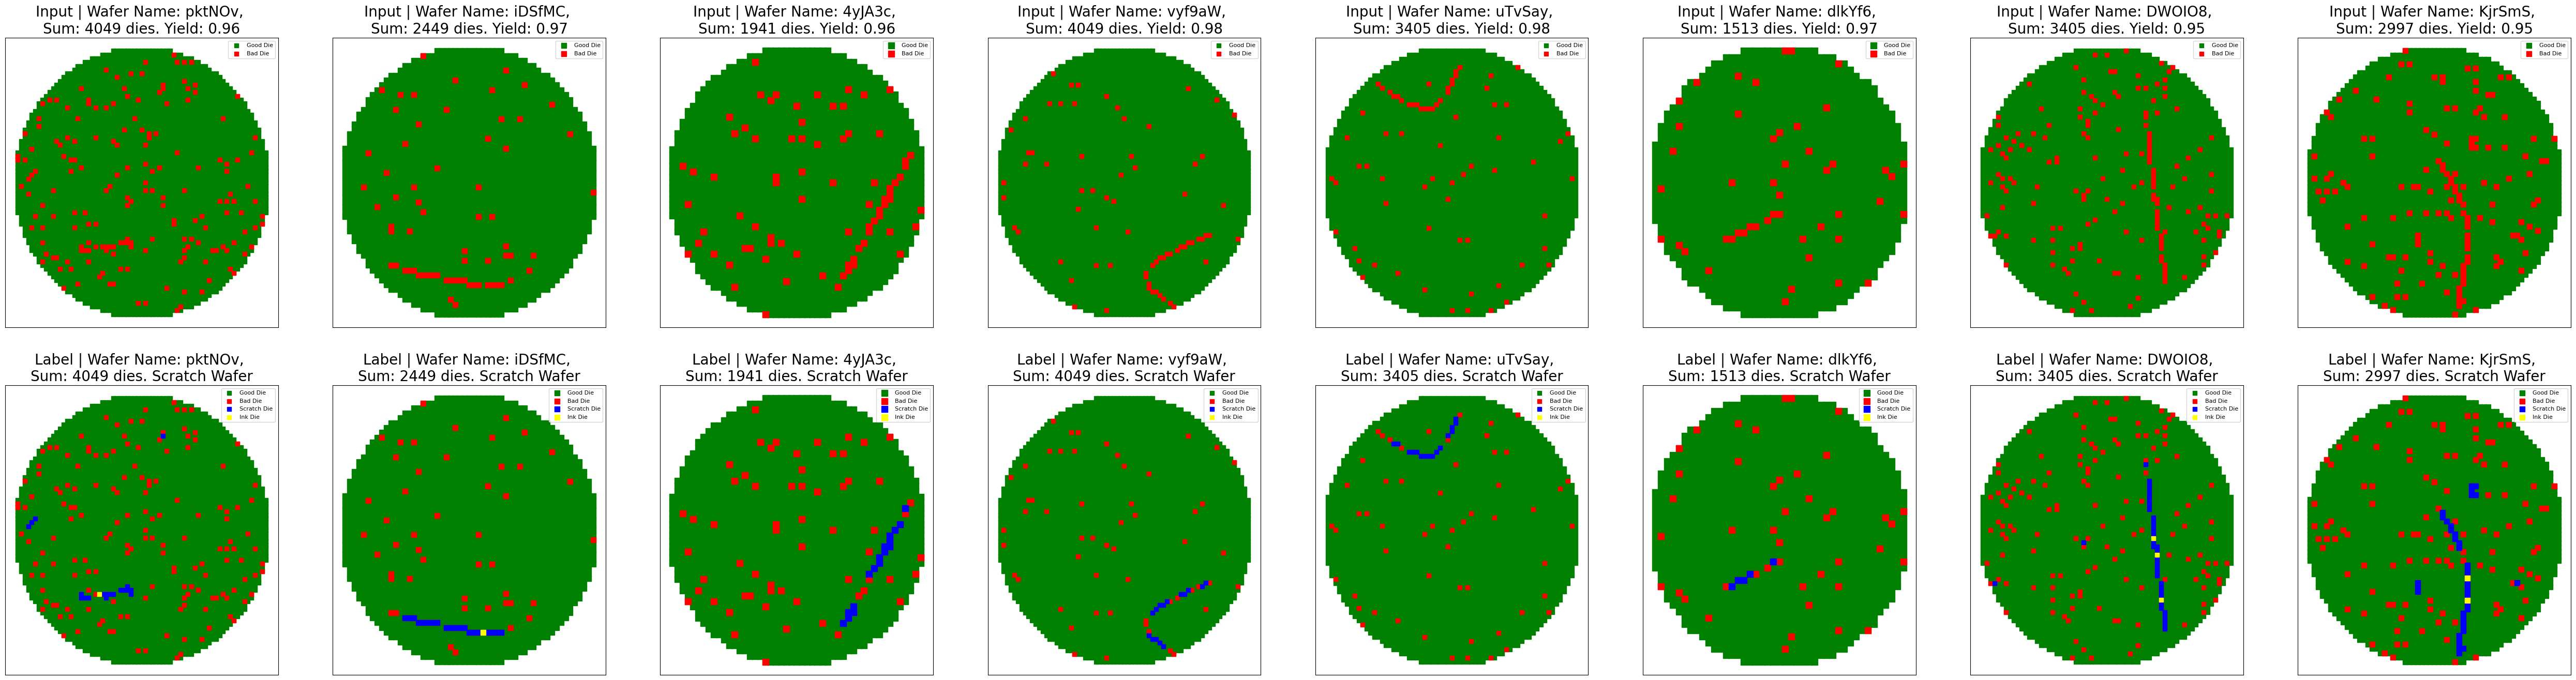

In [9]:
n_samples = 8
list_sample_train = [df.groupby('WaferName').get_group(group) for group in df['WaferName'].value_counts().sample(n_samples, random_state=20).index]
plot_wafer_maps(list_sample_train, figsize = 8, labels = True)

Looks like we did pretty well!

# Additional thoughts

This assignment was very fun for me to do!
Throughout the process, I encountered a number of challenges, such as deciding which features to engineer, understanding the limitations of my computer when working with large datasets, and solving performance bottlenecks using parallel computing by utilizing multiple CPU cores.  

Another significant challenge was the data being highly unbalanced, which required me to experiment with different solutions, such as resampling techniques and adjusting class weights, to ensure the model could generalize well.  
  
One frustrating issue I wasn’t able to fully resolve was that after long computations in Jupyter Notebook, the Python kernel would often freeze. This prevented me from running other cells and forced me to write large blocks of code in a single cell, which made the notebook harder to organize and read. It disrupted the workflow and made debugging more difficult.  
  
Despite these difficulties, there were many aspects of the project that I really enjoyed.  
  
Some of the things I found most enjoyable were experimenting with different machine learning models and seeing how small changes in parameters or features could drastically affect the results. I also enjoyed learning how to optimize performance using multiprocessing, which was something I hadn't deeply explored before. It was satisfying to see my code run faster and more efficiently after applying those techniques.  
  
Additionally, visualizing the data and the model's predictions helped me better understand the patterns within the dataset and made the project feel more interactive and insightful. Overall, I really liked the hands-on nature of the assignment, and it gave me a better appreciation for the practical challenges of working with real-world data.  